In [7]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [13]:
tickers = ['BTC','SOL','LTC','UNI','VET']
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

In [14]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [16]:
#log_returns = log_returns.dropna()

In [17]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          BTC       SOL       LTC          UNI       VET
BTC  0.001392  0.002926  0.001256     0.000968 -0.001010
SOL  0.002926  0.874495  0.027054     0.010865  0.079842
LTC  0.001256  0.027054  0.051275    -1.004799  0.029206
UNI  0.000968  0.010865 -1.004799  1101.202903  1.420500
VET -0.001010  0.079842  0.029206     1.420500  0.355835


In [18]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [19]:
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

Analyze the Optimal Portfolio

In [20]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
BTC: 0.4000
SOL: 0.0000
LTC: 0.2000
UNI: 0.0000
VET: 0.4000
Expected Annual Return: 0.1687
Expected Volatility: 0.2525
Sharpe Ratio: 0.5890


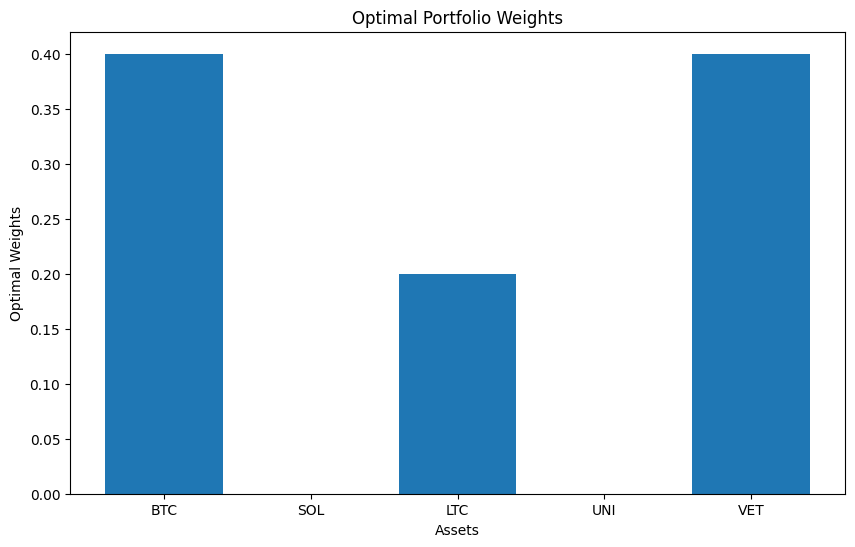

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()